In [2]:
# Import resources
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
import sys

# Access project directory 
base_dir = r"C:\Users\JAMES FARELL LATANNA\Downloads\Lastchance"
sys.path.append(base_dir)

# Paths
dataset_dir = base_dir
model_dir = os.path.join(base_dir, 'model')

In [4]:
from Dataset import get_dataset_dict
 
# Load datasets
dataset_dict = get_dataset_dict(dataset_dir)

In [5]:
from Datapipeline import Augmentation, Dataset
 
## PARAMETERS
AUGMENTATION = Augmentation.HIGH
CROSS_ENTROPY = True
DATASET = Dataset.FERPLUS
N_CLASSES = 8
ORIGINAL_PREPROCESSING = True

# Model file name
MODEL_NAME = 'ferplus_model_pd'

In [6]:
## HYPERPARAMETERS
BATCH_SIZE = 128
EPOCHS = 1000
DROPOUT_RATE = 0.10
LEARNING_RATE = 0.005
LEAKY_RELU_SLOPE = 0.02
LR_PATIENCE = 20
PATIENCE = 30
REGULARIZATION_RATE = 0.01

In [7]:
from data import get_data_pipeline  # Use the new function
from Datapipeline import DataPipelineParams

# Data pipeline parameters
pipeline_params = DataPipelineParams(dataset=DATASET,
                                     cross_entropy=CROSS_ENTROPY,
                                     original_preprocessing=ORIGINAL_PREPROCESSING,
                                     batch_size=BATCH_SIZE,
                                     augmentation=AUGMENTATION)

pipeline_params_test = DataPipelineParams(dataset=DATASET,
                                          original_preprocessing=ORIGINAL_PREPROCESSING,
                                          batch_size=BATCH_SIZE,
                                          augmentation=AUGMENTATION)

# Data pipelines
# Data pipelines
training_pipeline = get_data_pipeline(dataset_df=dataset_dict['train'],
                                      params=pipeline_params,
                                      shuffle=True)  # Shuffle for training
validation_pipeline = get_data_pipeline(dataset_df=dataset_dict['valid'],
                                        params=pipeline_params_test)
test_pipeline = get_data_pipeline(dataset_df=dataset_dict['test'],
                                  params=pipeline_params_test)


Number of elements: 27956
Number of elements: 3199
Number of elements: 3153


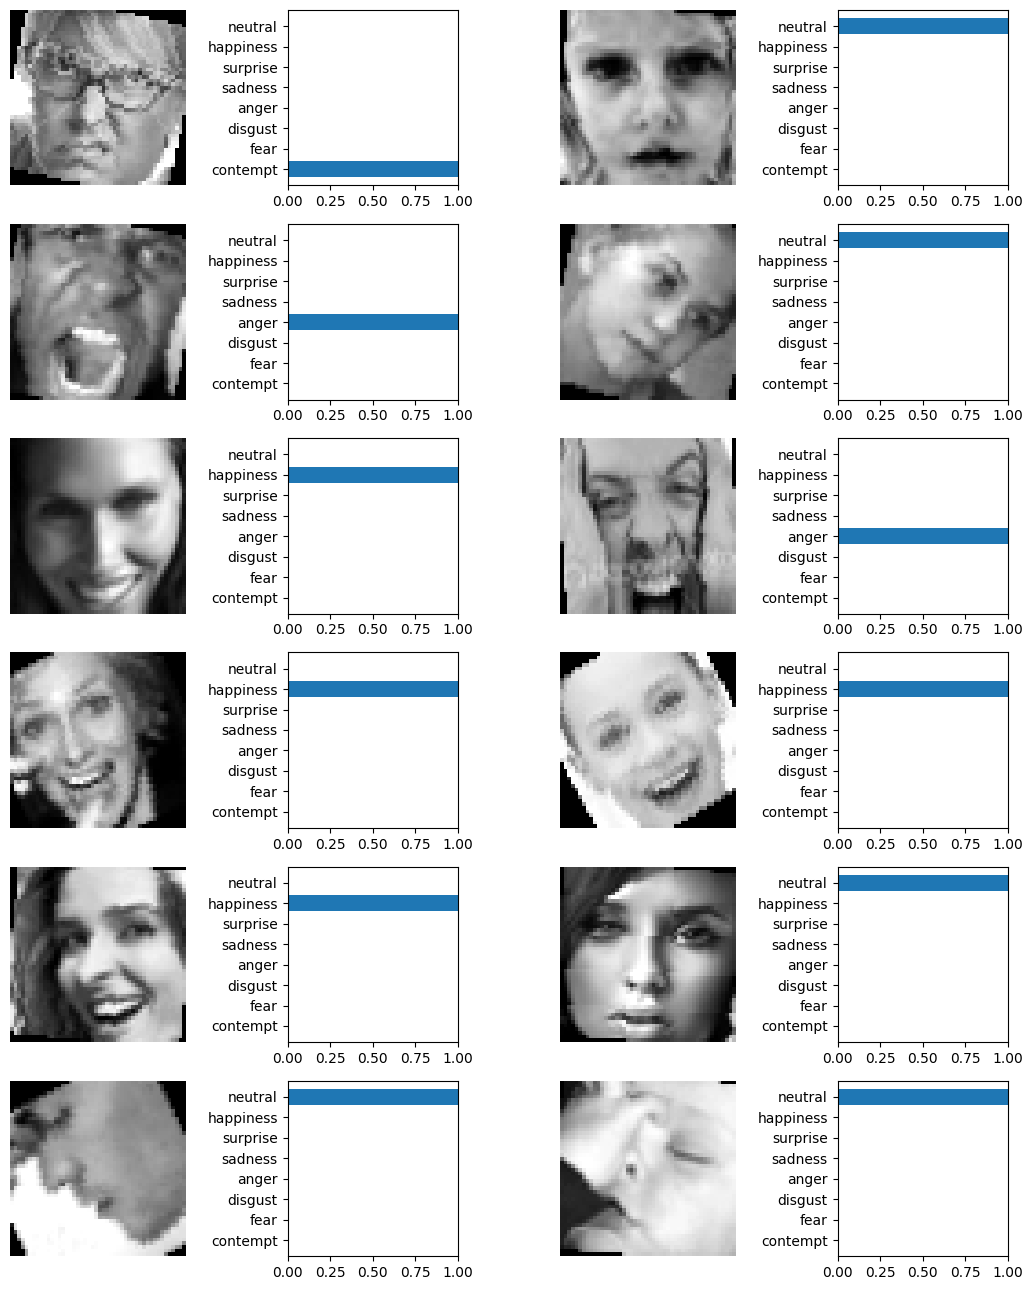

In [8]:
from data import get_fer_class_mapping, get_fer_plus_class_mapping
import predictions as ps

# Display sample imagesf
# Convert the DataLoader to an iterator and get the next batch
iterator = iter(test_pipeline)
image_batch, label_batch = next(iterator)

if DATASET == Dataset.FER:
    class_mapping = get_fer_class_mapping()
else:
    class_mapping = get_fer_plus_class_mapping()

if CROSS_ENTROPY:
    ps.display_cross_entropy_predictions(image_batch, 
                                         label_batch, 
                                        class_mapping)
else:
    ps.display_majority_predictions(image_batch, 
                                    label_batch, 
                                    class_mapping)

In [9]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [11]:
import models
from Datapipeline import Augmentation, Dataset
import torch
from torchinfo import summary

# Create an instance of the model
model = models.get_performance_model(leaky_relu_slope=LEAKY_RELU_SLOPE,
                                     dropout_rate=DROPOUT_RATE,
                                     regularization_rate=REGULARIZATION_RATE,
                                     n_classes=N_CLASSES,
                                     logits=True)

# Check model summary using torchinfo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print model summary
summary(model, input_size=(1, 1, 48, 48), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
PerformanceModel                         [1, 8]                    --
├─Conv2d: 1-1                            [1, 32, 48, 48]           320
├─BatchNorm2d: 1-2                       [1, 32, 48, 48]           64
├─Conv2d: 1-3                            [1, 32, 48, 48]           9,248
├─BatchNorm2d: 1-4                       [1, 32, 48, 48]           64
├─MaxPool2d: 1-5                         [1, 32, 24, 24]           --
├─Dropout2d: 1-6                         [1, 32, 24, 24]           --
├─Conv2d: 1-7                            [1, 64, 24, 24]           18,496
├─BatchNorm2d: 1-8                       [1, 64, 24, 24]           128
├─Conv2d: 1-9                            [1, 64, 24, 24]           36,928
├─BatchNorm2d: 1-10                      [1, 64, 24, 24]           128
├─MaxPool2d: 1-11                        [1, 64, 12, 12]           --
├─Dropout2d: 1-12                        [1, 64, 12, 12]           --
├

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Loss function
loss = nn.CrossEntropyLoss()  # Equivalent to CategoricalCrossentropy(from_logits=True)

# Optimizer (assuming you have a model instance called `model`)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [13]:
import torch
import os

# Early stopping parameters
best_val_loss = float('inf')
patience = PATIENCE  # Number of epochs to wait before stopping
counter = 0

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=LR_PATIENCE, min_lr=0.001)


# Model checkpoint paths
model_file_path_acc = os.path.join(model_dir, MODEL_NAME + '_acc.pth')
model_file_path_loss = os.path.join(model_dir, MODEL_NAME + '_loss.pth')


In [14]:
criterion = nn.CrossEntropyLoss()  # Define this before training


In [16]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}  # ✅ Store training data


In [17]:
from tqdm import tqdm

In [18]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # ✅ Progress bar for training loop
    progress_bar = tqdm(training_pipeline, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # ✅ Training accuracy calculation
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        # ✅ Update progress bar with live loss info
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(training_pipeline)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    # ✅ Progress bar for validation loop
    val_progress_bar = tqdm(validation_pipeline, desc=f"Validating Epoch {epoch+1}/{EPOCHS}", leave=True)

    with torch.no_grad():
        for images, labels in val_progress_bar:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # ✅ Validation accuracy calculation
            _, predicted = torch.max(outputs, 1)

            # ✅ Fix: Convert labels from one-hot encoding to class indices if needed
            if labels.dim() > 1:
                labels = labels.argmax(dim=1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_loss /= len(validation_pipeline)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # ✅ Save history for later graphing
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_accuracy)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_accuracy)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), model_file_path_loss)  # Save best loss model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

    # Save best accuracy model
    if val_accuracy > best_val_acc:  
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), model_file_path_acc)  # Save best accuracy model

    # Reduce learning rate if needed
    scheduler.step(val_loss)

Epoch 1/1000:   0%|          | 0/219 [00:00<?, ?it/s]

Validating Epoch 1/1000: 100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Epoch 1/1000, Train Loss: 1.2072, Train Acc: 0.5759, Val Loss: 1.0319, Val Acc: 0.6389


Validating Epoch 2/1000: 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epoch 2/1000, Train Loss: 1.0786, Train Acc: 0.6193, Val Loss: 0.9196, Val Acc: 0.6774


Validating Epoch 3/1000: 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epoch 3/1000, Train Loss: 0.9734, Train Acc: 0.6554, Val Loss: 0.8553, Val Acc: 0.6905


Validating Epoch 4/1000: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Epoch 4/1000, Train Loss: 0.9075, Train Acc: 0.6793, Val Loss: 0.7831, Val Acc: 0.7209


Validating Epoch 5/1000: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Epoch 5/1000, Train Loss: 0.8654, Train Acc: 0.6919, Val Loss: 0.7324, Val Acc: 0.7393


Validating Epoch 6/1000: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


Epoch 6/1000, Train Loss: 0.8320, Train Acc: 0.7025, Val Loss: 0.7327, Val Acc: 0.7446


Validating Epoch 7/1000: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s]


Epoch 7/1000, Train Loss: 0.8069, Train Acc: 0.7105, Val Loss: 0.6744, Val Acc: 0.7627


Validating Epoch 8/1000: 100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Epoch 8/1000, Train Loss: 0.7827, Train Acc: 0.7185, Val Loss: 0.6733, Val Acc: 0.7518


Validating Epoch 9/1000: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Epoch 9/1000, Train Loss: 0.7575, Train Acc: 0.7288, Val Loss: 0.6274, Val Acc: 0.7834


Validating Epoch 10/1000: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 10/1000, Train Loss: 0.7393, Train Acc: 0.7347, Val Loss: 0.6924, Val Acc: 0.7518


Validating Epoch 11/1000: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s]


Epoch 11/1000, Train Loss: 0.7314, Train Acc: 0.7369, Val Loss: 0.6250, Val Acc: 0.7784


Validating Epoch 12/1000: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s]


Epoch 12/1000, Train Loss: 0.7143, Train Acc: 0.7445, Val Loss: 0.6453, Val Acc: 0.7724


Validating Epoch 13/1000: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]


Epoch 13/1000, Train Loss: 0.6962, Train Acc: 0.7502, Val Loss: 0.6132, Val Acc: 0.7746


Validating Epoch 14/1000: 100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Epoch 14/1000, Train Loss: 0.6928, Train Acc: 0.7528, Val Loss: 0.5990, Val Acc: 0.7906


Validating Epoch 15/1000: 100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Epoch 15/1000, Train Loss: 0.6824, Train Acc: 0.7527, Val Loss: 0.5791, Val Acc: 0.7924


Validating Epoch 16/1000: 100%|██████████| 25/25 [00:11<00:00,  2.19it/s]


Epoch 16/1000, Train Loss: 0.6672, Train Acc: 0.7589, Val Loss: 0.5884, Val Acc: 0.7887


Validating Epoch 17/1000: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s]


Epoch 17/1000, Train Loss: 0.6607, Train Acc: 0.7611, Val Loss: 0.5850, Val Acc: 0.7931


Validating Epoch 18/1000: 100%|██████████| 25/25 [00:11<00:00,  2.19it/s]


Epoch 18/1000, Train Loss: 0.6504, Train Acc: 0.7663, Val Loss: 0.5758, Val Acc: 0.7896


Validating Epoch 19/1000: 100%|██████████| 25/25 [00:11<00:00,  2.21it/s]


Epoch 19/1000, Train Loss: 0.6462, Train Acc: 0.7697, Val Loss: 0.5657, Val Acc: 0.7977


Validating Epoch 20/1000: 100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Epoch 20/1000, Train Loss: 0.6348, Train Acc: 0.7714, Val Loss: 0.5560, Val Acc: 0.8015


Validating Epoch 21/1000: 100%|██████████| 25/25 [00:11<00:00,  2.22it/s]


Epoch 21/1000, Train Loss: 0.6302, Train Acc: 0.7711, Val Loss: 0.5746, Val Acc: 0.7924


Validating Epoch 22/1000: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Epoch 22/1000, Train Loss: 0.6260, Train Acc: 0.7755, Val Loss: 0.5645, Val Acc: 0.7881


Validating Epoch 23/1000: 100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Epoch 23/1000, Train Loss: 0.6124, Train Acc: 0.7776, Val Loss: 0.5305, Val Acc: 0.8090


Validating Epoch 24/1000: 100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Epoch 24/1000, Train Loss: 0.6117, Train Acc: 0.7788, Val Loss: 0.5151, Val Acc: 0.8174


Validating Epoch 25/1000: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s]


Epoch 25/1000, Train Loss: 0.6041, Train Acc: 0.7811, Val Loss: 0.5360, Val Acc: 0.8090


Validating Epoch 26/1000: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Epoch 26/1000, Train Loss: 0.5994, Train Acc: 0.7829, Val Loss: 0.5286, Val Acc: 0.8115


Validating Epoch 27/1000: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Epoch 27/1000, Train Loss: 0.5905, Train Acc: 0.7832, Val Loss: 0.5194, Val Acc: 0.8168


Validating Epoch 28/1000: 100%|██████████| 25/25 [00:11<00:00,  2.21it/s]


Epoch 28/1000, Train Loss: 0.5864, Train Acc: 0.7868, Val Loss: 0.5386, Val Acc: 0.8046


Validating Epoch 29/1000: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


Epoch 29/1000, Train Loss: 0.5810, Train Acc: 0.7870, Val Loss: 0.5388, Val Acc: 0.8071


Validating Epoch 30/1000: 100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


Epoch 30/1000, Train Loss: 0.5736, Train Acc: 0.7904, Val Loss: 0.5217, Val Acc: 0.8159


Validating Epoch 31/1000: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s]


Epoch 31/1000, Train Loss: 0.5732, Train Acc: 0.7912, Val Loss: 0.5184, Val Acc: 0.8131


Validating Epoch 32/1000: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]


Epoch 32/1000, Train Loss: 0.5665, Train Acc: 0.7968, Val Loss: 0.5132, Val Acc: 0.8124


Validating Epoch 33/1000: 100%|██████████| 25/25 [00:11<00:00,  2.21it/s]


Epoch 33/1000, Train Loss: 0.5647, Train Acc: 0.7946, Val Loss: 0.5082, Val Acc: 0.8218


Validating Epoch 34/1000: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


Epoch 34/1000, Train Loss: 0.5590, Train Acc: 0.7973, Val Loss: 0.5107, Val Acc: 0.8149


Validating Epoch 35/1000: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]


Epoch 35/1000, Train Loss: 0.5537, Train Acc: 0.7972, Val Loss: 0.4987, Val Acc: 0.8240


Validating Epoch 36/1000: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Epoch 36/1000, Train Loss: 0.5499, Train Acc: 0.8010, Val Loss: 0.5042, Val Acc: 0.8184


Validating Epoch 37/1000: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s]


Epoch 37/1000, Train Loss: 0.5520, Train Acc: 0.7984, Val Loss: 0.5146, Val Acc: 0.8187


Validating Epoch 38/1000: 100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Epoch 38/1000, Train Loss: 0.5448, Train Acc: 0.8020, Val Loss: 0.5244, Val Acc: 0.8124


Validating Epoch 39/1000: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s]


Epoch 39/1000, Train Loss: 0.5407, Train Acc: 0.8032, Val Loss: 0.4764, Val Acc: 0.8309


Validating Epoch 40/1000: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]


Epoch 40/1000, Train Loss: 0.5377, Train Acc: 0.8056, Val Loss: 0.4876, Val Acc: 0.8299


Validating Epoch 41/1000: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]


Epoch 41/1000, Train Loss: 0.5352, Train Acc: 0.8031, Val Loss: 0.4888, Val Acc: 0.8274


Validating Epoch 42/1000: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]


Epoch 42/1000, Train Loss: 0.5253, Train Acc: 0.8058, Val Loss: 0.4759, Val Acc: 0.8318


Validating Epoch 43/1000: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]


Epoch 43/1000, Train Loss: 0.5235, Train Acc: 0.8086, Val Loss: 0.4929, Val Acc: 0.8262


Validating Epoch 44/1000: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s]


Epoch 44/1000, Train Loss: 0.5267, Train Acc: 0.8072, Val Loss: 0.4789, Val Acc: 0.8287


Validating Epoch 45/1000: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]


Epoch 45/1000, Train Loss: 0.5195, Train Acc: 0.8100, Val Loss: 0.4864, Val Acc: 0.8228


Validating Epoch 46/1000: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]


Epoch 46/1000, Train Loss: 0.5127, Train Acc: 0.8133, Val Loss: 0.4938, Val Acc: 0.8278


Validating Epoch 47/1000: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epoch 47/1000, Train Loss: 0.5160, Train Acc: 0.8118, Val Loss: 0.5177, Val Acc: 0.8131


Validating Epoch 48/1000: 100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Epoch 48/1000, Train Loss: 0.5110, Train Acc: 0.8114, Val Loss: 0.4952, Val Acc: 0.8174


Validating Epoch 49/1000: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Epoch 49/1000, Train Loss: 0.5084, Train Acc: 0.8122, Val Loss: 0.4976, Val Acc: 0.8215


Validating Epoch 50/1000: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s]


Epoch 50/1000, Train Loss: 0.5063, Train Acc: 0.8107, Val Loss: 0.4701, Val Acc: 0.8299


Validating Epoch 51/1000: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Epoch 51/1000, Train Loss: 0.4980, Train Acc: 0.8157, Val Loss: 0.4916, Val Acc: 0.8243


Validating Epoch 52/1000: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s]


Epoch 52/1000, Train Loss: 0.4975, Train Acc: 0.8180, Val Loss: 0.4818, Val Acc: 0.8334


Validating Epoch 53/1000: 100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Epoch 53/1000, Train Loss: 0.4961, Train Acc: 0.8170, Val Loss: 0.4894, Val Acc: 0.8274


Validating Epoch 54/1000: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Epoch 54/1000, Train Loss: 0.4952, Train Acc: 0.8174, Val Loss: 0.4781, Val Acc: 0.8321


Validating Epoch 55/1000: 100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Epoch 55/1000, Train Loss: 0.4904, Train Acc: 0.8197, Val Loss: 0.4734, Val Acc: 0.8337


Validating Epoch 56/1000: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


Epoch 56/1000, Train Loss: 0.4909, Train Acc: 0.8201, Val Loss: 0.4546, Val Acc: 0.8274


Validating Epoch 57/1000: 100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Epoch 57/1000, Train Loss: 0.4831, Train Acc: 0.8248, Val Loss: 0.4817, Val Acc: 0.8221


Validating Epoch 58/1000: 100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


Epoch 58/1000, Train Loss: 0.4818, Train Acc: 0.8236, Val Loss: 0.4706, Val Acc: 0.8349


Validating Epoch 59/1000: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Epoch 59/1000, Train Loss: 0.4801, Train Acc: 0.8230, Val Loss: 0.4755, Val Acc: 0.8362


Validating Epoch 60/1000: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


Epoch 60/1000, Train Loss: 0.4739, Train Acc: 0.8244, Val Loss: 0.4708, Val Acc: 0.8306


Validating Epoch 61/1000: 100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Epoch 61/1000, Train Loss: 0.4686, Train Acc: 0.8276, Val Loss: 0.4753, Val Acc: 0.8293


Validating Epoch 62/1000: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


Epoch 62/1000, Train Loss: 0.4652, Train Acc: 0.8268, Val Loss: 0.4679, Val Acc: 0.8278


Validating Epoch 63/1000: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Epoch 63/1000, Train Loss: 0.4675, Train Acc: 0.8262, Val Loss: 0.4782, Val Acc: 0.8234


Validating Epoch 64/1000: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Epoch 64/1000, Train Loss: 0.4619, Train Acc: 0.8299, Val Loss: 0.4675, Val Acc: 0.8349


Validating Epoch 65/1000: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Epoch 65/1000, Train Loss: 0.4610, Train Acc: 0.8290, Val Loss: 0.4845, Val Acc: 0.8274


Validating Epoch 66/1000: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Epoch 66/1000, Train Loss: 0.4627, Train Acc: 0.8266, Val Loss: 0.4718, Val Acc: 0.8340


Validating Epoch 67/1000: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


Epoch 67/1000, Train Loss: 0.4609, Train Acc: 0.8320, Val Loss: 0.4449, Val Acc: 0.8378


Validating Epoch 68/1000: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


Epoch 68/1000, Train Loss: 0.4517, Train Acc: 0.8318, Val Loss: 0.4612, Val Acc: 0.8428


Validating Epoch 69/1000: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Epoch 69/1000, Train Loss: 0.4531, Train Acc: 0.8331, Val Loss: 0.4437, Val Acc: 0.8362


Validating Epoch 70/1000: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Epoch 70/1000, Train Loss: 0.4519, Train Acc: 0.8334, Val Loss: 0.4669, Val Acc: 0.8331


Validating Epoch 71/1000: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s]


Epoch 71/1000, Train Loss: 0.4451, Train Acc: 0.8366, Val Loss: 0.4682, Val Acc: 0.8321


Validating Epoch 72/1000: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s]


Epoch 72/1000, Train Loss: 0.4492, Train Acc: 0.8338, Val Loss: 0.4844, Val Acc: 0.8296


Validating Epoch 73/1000: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


Epoch 73/1000, Train Loss: 0.4452, Train Acc: 0.8332, Val Loss: 0.4910, Val Acc: 0.8303


Validating Epoch 74/1000: 100%|██████████| 25/25 [00:11<00:00,  2.19it/s]


Epoch 74/1000, Train Loss: 0.4462, Train Acc: 0.8353, Val Loss: 0.4685, Val Acc: 0.8312


Validating Epoch 75/1000: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


Epoch 75/1000, Train Loss: 0.4424, Train Acc: 0.8371, Val Loss: 0.4538, Val Acc: 0.8365


Validating Epoch 76/1000: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


Epoch 76/1000, Train Loss: 0.4394, Train Acc: 0.8380, Val Loss: 0.4690, Val Acc: 0.8371


Validating Epoch 77/1000: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s]


Epoch 77/1000, Train Loss: 0.4457, Train Acc: 0.8333, Val Loss: 0.4482, Val Acc: 0.8462


Validating Epoch 78/1000: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


Epoch 78/1000, Train Loss: 0.4341, Train Acc: 0.8372, Val Loss: 0.4599, Val Acc: 0.8374


Validating Epoch 79/1000: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Epoch 79/1000, Train Loss: 0.4417, Train Acc: 0.8346, Val Loss: 0.4826, Val Acc: 0.8312


Validating Epoch 80/1000: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Epoch 80/1000, Train Loss: 0.4354, Train Acc: 0.8381, Val Loss: 0.4692, Val Acc: 0.8371


Validating Epoch 81/1000: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Epoch 81/1000, Train Loss: 0.4272, Train Acc: 0.8412, Val Loss: 0.4723, Val Acc: 0.8349


Validating Epoch 82/1000: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Epoch 82/1000, Train Loss: 0.4338, Train Acc: 0.8407, Val Loss: 0.4488, Val Acc: 0.8306


Validating Epoch 83/1000: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Epoch 83/1000, Train Loss: 0.4288, Train Acc: 0.8414, Val Loss: 0.4639, Val Acc: 0.8343


Validating Epoch 84/1000: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


Epoch 84/1000, Train Loss: 0.4299, Train Acc: 0.8429, Val Loss: 0.4652, Val Acc: 0.8418


Validating Epoch 85/1000: 100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Epoch 85/1000, Train Loss: 0.4250, Train Acc: 0.8418, Val Loss: 0.4841, Val Acc: 0.8384


Validating Epoch 86/1000: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


Epoch 86/1000, Train Loss: 0.4200, Train Acc: 0.8436, Val Loss: 0.4395, Val Acc: 0.8412


Validating Epoch 87/1000: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]


Epoch 87/1000, Train Loss: 0.4209, Train Acc: 0.8441, Val Loss: 0.4690, Val Acc: 0.8346


Validating Epoch 88/1000: 100%|██████████| 25/25 [00:07<00:00,  3.38it/s]


Epoch 88/1000, Train Loss: 0.4110, Train Acc: 0.8474, Val Loss: 0.4670, Val Acc: 0.8378


Validating Epoch 89/1000: 100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Epoch 89/1000, Train Loss: 0.4143, Train Acc: 0.8464, Val Loss: 0.4757, Val Acc: 0.8368


Validating Epoch 90/1000: 100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Epoch 90/1000, Train Loss: 0.4204, Train Acc: 0.8436, Val Loss: 0.4621, Val Acc: 0.8384


Validating Epoch 91/1000: 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Epoch 91/1000, Train Loss: 0.4143, Train Acc: 0.8457, Val Loss: 0.4690, Val Acc: 0.8331


Validating Epoch 92/1000: 100%|██████████| 25/25 [00:12<00:00,  1.98it/s]


Epoch 92/1000, Train Loss: 0.4011, Train Acc: 0.8487, Val Loss: 0.4856, Val Acc: 0.8309


Validating Epoch 93/1000: 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epoch 93/1000, Train Loss: 0.4149, Train Acc: 0.8467, Val Loss: 0.4573, Val Acc: 0.8393


Validating Epoch 94/1000: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s]


Epoch 94/1000, Train Loss: 0.4048, Train Acc: 0.8500, Val Loss: 0.5078, Val Acc: 0.8262


Validating Epoch 95/1000: 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Epoch 95/1000, Train Loss: 0.4101, Train Acc: 0.8463, Val Loss: 0.4840, Val Acc: 0.8346


Validating Epoch 96/1000: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]


Epoch 96/1000, Train Loss: 0.4120, Train Acc: 0.8459, Val Loss: 0.4543, Val Acc: 0.8399


Validating Epoch 97/1000: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Epoch 97/1000, Train Loss: 0.3984, Train Acc: 0.8536, Val Loss: 0.4683, Val Acc: 0.8368


Validating Epoch 98/1000: 100%|██████████| 25/25 [00:11<00:00,  2.21it/s]


Epoch 98/1000, Train Loss: 0.3979, Train Acc: 0.8514, Val Loss: 0.4712, Val Acc: 0.8353


Validating Epoch 99/1000: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s]


Epoch 99/1000, Train Loss: 0.3992, Train Acc: 0.8512, Val Loss: 0.4490, Val Acc: 0.8349


Validating Epoch 100/1000: 100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Epoch 100/1000, Train Loss: 0.3950, Train Acc: 0.8540, Val Loss: 0.4541, Val Acc: 0.8399


Validating Epoch 101/1000: 100%|██████████| 25/25 [00:11<00:00,  2.19it/s]


Epoch 101/1000, Train Loss: 0.3992, Train Acc: 0.8528, Val Loss: 0.4693, Val Acc: 0.8403


Validating Epoch 102/1000: 100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Epoch 102/1000, Train Loss: 0.3931, Train Acc: 0.8548, Val Loss: 0.4636, Val Acc: 0.8406


Validating Epoch 103/1000: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


Epoch 103/1000, Train Loss: 0.3887, Train Acc: 0.8560, Val Loss: 0.4575, Val Acc: 0.8462


Validating Epoch 104/1000: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]


Epoch 104/1000, Train Loss: 0.3901, Train Acc: 0.8552, Val Loss: 0.4550, Val Acc: 0.8421


Validating Epoch 105/1000: 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


Epoch 105/1000, Train Loss: 0.3913, Train Acc: 0.8545, Val Loss: 0.4806, Val Acc: 0.8334


Validating Epoch 106/1000: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


Epoch 106/1000, Train Loss: 0.3892, Train Acc: 0.8558, Val Loss: 0.4713, Val Acc: 0.8387


Validating Epoch 107/1000: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Epoch 107/1000, Train Loss: 0.3837, Train Acc: 0.8574, Val Loss: 0.4460, Val Acc: 0.8446


Validating Epoch 108/1000: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


Epoch 108/1000, Train Loss: 0.3563, Train Acc: 0.8661, Val Loss: 0.4391, Val Acc: 0.8484


Validating Epoch 109/1000: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Epoch 109/1000, Train Loss: 0.3401, Train Acc: 0.8729, Val Loss: 0.4447, Val Acc: 0.8525


Validating Epoch 110/1000: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Epoch 110/1000, Train Loss: 0.3452, Train Acc: 0.8715, Val Loss: 0.4321, Val Acc: 0.8503


Validating Epoch 111/1000: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 111/1000, Train Loss: 0.3372, Train Acc: 0.8745, Val Loss: 0.4467, Val Acc: 0.8437


Validating Epoch 112/1000: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 112/1000, Train Loss: 0.3358, Train Acc: 0.8750, Val Loss: 0.4491, Val Acc: 0.8440


Validating Epoch 113/1000: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Epoch 113/1000, Train Loss: 0.3273, Train Acc: 0.8793, Val Loss: 0.4408, Val Acc: 0.8468


Validating Epoch 114/1000: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch 114/1000, Train Loss: 0.3350, Train Acc: 0.8755, Val Loss: 0.4473, Val Acc: 0.8543


Validating Epoch 115/1000: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Epoch 115/1000, Train Loss: 0.3281, Train Acc: 0.8754, Val Loss: 0.4451, Val Acc: 0.8412


Validating Epoch 116/1000: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Epoch 116/1000, Train Loss: 0.3346, Train Acc: 0.8755, Val Loss: 0.4543, Val Acc: 0.8418


Validating Epoch 117/1000: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


Epoch 117/1000, Train Loss: 0.3360, Train Acc: 0.8756, Val Loss: 0.4454, Val Acc: 0.8462


Validating Epoch 118/1000: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Epoch 118/1000, Train Loss: 0.3268, Train Acc: 0.8774, Val Loss: 0.4447, Val Acc: 0.8450


Validating Epoch 119/1000: 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Epoch 119/1000, Train Loss: 0.3263, Train Acc: 0.8776, Val Loss: 0.4591, Val Acc: 0.8484


Validating Epoch 120/1000: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Epoch 120/1000, Train Loss: 0.3260, Train Acc: 0.8768, Val Loss: 0.4325, Val Acc: 0.8575


Validating Epoch 121/1000: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Epoch 121/1000, Train Loss: 0.3240, Train Acc: 0.8776, Val Loss: 0.4386, Val Acc: 0.8490


Validating Epoch 122/1000: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Epoch 122/1000, Train Loss: 0.3201, Train Acc: 0.8820, Val Loss: 0.4383, Val Acc: 0.8421


Validating Epoch 123/1000: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


Epoch 123/1000, Train Loss: 0.3225, Train Acc: 0.8804, Val Loss: 0.4613, Val Acc: 0.8471


Validating Epoch 124/1000: 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


Epoch 124/1000, Train Loss: 0.3152, Train Acc: 0.8815, Val Loss: 0.4451, Val Acc: 0.8512


Validating Epoch 125/1000: 100%|██████████| 25/25 [00:07<00:00,  3.46it/s]


Epoch 125/1000, Train Loss: 0.3200, Train Acc: 0.8800, Val Loss: 0.4328, Val Acc: 0.8537


Validating Epoch 126/1000: 100%|██████████| 25/25 [00:07<00:00,  3.48it/s]


Epoch 126/1000, Train Loss: 0.3119, Train Acc: 0.8829, Val Loss: 0.4571, Val Acc: 0.8475


Validating Epoch 127/1000: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


Epoch 127/1000, Train Loss: 0.3166, Train Acc: 0.8825, Val Loss: 0.4286, Val Acc: 0.8559


Validating Epoch 128/1000: 100%|██████████| 25/25 [00:07<00:00,  3.50it/s]


Epoch 128/1000, Train Loss: 0.3171, Train Acc: 0.8815, Val Loss: 0.4261, Val Acc: 0.8528


Validating Epoch 129/1000: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]


Epoch 129/1000, Train Loss: 0.3106, Train Acc: 0.8846, Val Loss: 0.4442, Val Acc: 0.8553


Validating Epoch 130/1000: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Epoch 130/1000, Train Loss: 0.3097, Train Acc: 0.8839, Val Loss: 0.4448, Val Acc: 0.8559


Validating Epoch 131/1000: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Epoch 131/1000, Train Loss: 0.3079, Train Acc: 0.8866, Val Loss: 0.4495, Val Acc: 0.8528


Validating Epoch 132/1000: 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Epoch 132/1000, Train Loss: 0.3031, Train Acc: 0.8846, Val Loss: 0.4585, Val Acc: 0.8506


Validating Epoch 133/1000: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


Epoch 133/1000, Train Loss: 0.3082, Train Acc: 0.8824, Val Loss: 0.4763, Val Acc: 0.8428


Validating Epoch 134/1000: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Epoch 134/1000, Train Loss: 0.3041, Train Acc: 0.8851, Val Loss: 0.4607, Val Acc: 0.8546


Validating Epoch 135/1000: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Epoch 135/1000, Train Loss: 0.3002, Train Acc: 0.8890, Val Loss: 0.4612, Val Acc: 0.8537


Validating Epoch 136/1000: 100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Epoch 136/1000, Train Loss: 0.3077, Train Acc: 0.8844, Val Loss: 0.4626, Val Acc: 0.8487


Validating Epoch 137/1000: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Epoch 137/1000, Train Loss: 0.3005, Train Acc: 0.8875, Val Loss: 0.4516, Val Acc: 0.8456


Validating Epoch 138/1000: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Epoch 138/1000, Train Loss: 0.3034, Train Acc: 0.8873, Val Loss: 0.4637, Val Acc: 0.8431


Validating Epoch 139/1000: 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]


Epoch 139/1000, Train Loss: 0.2935, Train Acc: 0.8893, Val Loss: 0.4565, Val Acc: 0.8475


Validating Epoch 140/1000: 100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Epoch 140/1000, Train Loss: 0.3080, Train Acc: 0.8855, Val Loss: 0.4528, Val Acc: 0.8487


Validating Epoch 141/1000: 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]


Epoch 141/1000, Train Loss: 0.2992, Train Acc: 0.8869, Val Loss: 0.4573, Val Acc: 0.8521


Validating Epoch 142/1000: 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


Epoch 142/1000, Train Loss: 0.2968, Train Acc: 0.8887, Val Loss: 0.4472, Val Acc: 0.8500


Validating Epoch 143/1000: 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


Epoch 143/1000, Train Loss: 0.2951, Train Acc: 0.8885, Val Loss: 0.4472, Val Acc: 0.8465


Validating Epoch 144/1000: 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


Epoch 144/1000, Train Loss: 0.2994, Train Acc: 0.8863, Val Loss: 0.4552, Val Acc: 0.8471


Validating Epoch 145/1000: 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


Epoch 145/1000, Train Loss: 0.2979, Train Acc: 0.8882, Val Loss: 0.4680, Val Acc: 0.8493


Validating Epoch 146/1000: 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


Epoch 146/1000, Train Loss: 0.2963, Train Acc: 0.8874, Val Loss: 0.4779, Val Acc: 0.8431


Validating Epoch 147/1000: 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


Epoch 147/1000, Train Loss: 0.2969, Train Acc: 0.8903, Val Loss: 0.4418, Val Acc: 0.8537


Validating Epoch 148/1000: 100%|██████████| 25/25 [00:07<00:00,  3.14it/s]


Epoch 148/1000, Train Loss: 0.2965, Train Acc: 0.8887, Val Loss: 0.4733, Val Acc: 0.8478


Validating Epoch 149/1000: 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]


Epoch 149/1000, Train Loss: 0.2953, Train Acc: 0.8880, Val Loss: 0.4755, Val Acc: 0.8450


Validating Epoch 150/1000: 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]


Epoch 150/1000, Train Loss: 0.2819, Train Acc: 0.8941, Val Loss: 0.4515, Val Acc: 0.8512


Validating Epoch 151/1000: 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


Epoch 151/1000, Train Loss: 0.2687, Train Acc: 0.8993, Val Loss: 0.4597, Val Acc: 0.8584


Validating Epoch 152/1000: 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


Epoch 152/1000, Train Loss: 0.2691, Train Acc: 0.9004, Val Loss: 0.4655, Val Acc: 0.8484


Validating Epoch 153/1000: 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]


Epoch 153/1000, Train Loss: 0.2670, Train Acc: 0.9013, Val Loss: 0.4535, Val Acc: 0.8540


Validating Epoch 154/1000: 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


Epoch 154/1000, Train Loss: 0.2675, Train Acc: 0.9010, Val Loss: 0.4683, Val Acc: 0.8456


Validating Epoch 155/1000: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Epoch 155/1000, Train Loss: 0.2650, Train Acc: 0.9008, Val Loss: 0.4580, Val Acc: 0.8509


Validating Epoch 156/1000: 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


Epoch 156/1000, Train Loss: 0.2615, Train Acc: 0.9019, Val Loss: 0.4562, Val Acc: 0.8571


Validating Epoch 157/1000: 100%|██████████| 25/25 [00:07<00:00,  3.18it/s]


Epoch 157/1000, Train Loss: 0.2596, Train Acc: 0.9027, Val Loss: 0.4440, Val Acc: 0.8584


Validating Epoch 158/1000: 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

Epoch 158/1000, Train Loss: 0.2654, Train Acc: 0.9002, Val Loss: 0.4558, Val Acc: 0.8525
Early stopping triggered.


In [21]:
import torch

# Load model
model_file_path_acc = r".\model\ferplus_model_pd_acc.pth"
model.load_state_dict(torch.load(model_file_path_acc, map_location=device))  # Ensure correct device
model.to(device)
model.eval()

PerformanceModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(

In [22]:
# Initialize test metrics
test_loss = 0.0
correct = 0
total = 0

In [23]:
# Check if dataloader is empty
if len(test_pipeline) == 0:
    print("⚠️ Warning: test_pipeline is empty! Check your dataloader.")
else:
    print("✅ Test dataloader loaded. Running evaluation...")


✅ Test dataloader loaded. Running evaluation...


In [24]:
# Evaluation loop
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_pipeline):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        # Debugging prints
        print(f"[Batch {batch_idx}] Outputs: {outputs.shape}, Labels: {labels.shape}")

        # Convert labels if needed
        if labels.dim() > 1:  
            labels = labels.argmax(1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total if total > 0 else 0  # Avoid division by zero
test_loss /= len(test_pipeline) if len(test_pipeline) > 0 else 1

print(f"📊 Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

[Batch 0] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 1] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 2] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 3] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 4] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 5] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 6] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 7] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 8] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 9] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 10] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 11] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 12] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 13] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 14] Outpu